In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hba1c-15-aout-2024-p2/HBA1C-15-AOUT-2024-p2.csv


In [29]:
#loading the data set and lookign through it 
df = pd.read_csv('/kaggle/input/hba1c-15-aout-2024-p2/HBA1C-15-AOUT-2024-p2.csv')
df.drop(['Unnamed: 0','Numero','Date'],axis=1,inplace=True)
df.drop(['Insuline','Ado','Nom'],axis=1,inplace=True)
df = df[df['Retour'] == 1]
df.drop('Retour',axis=1,inplace=True)

In [30]:
display(df.head())
df.dtypes


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Age,%,Type,Poids
0,65.0,8.3,2em TYPE,NaN
1,26.0,7.0,1er type,NaN
2,65.0,13.0,2em TYPE,NaN
3,50.0,7.3,2em TYPE,NaN
4,57.0,8.5,2em TYPE,NaN


Age      float64
%        float64
Type      object
Poids    float64
dtype: object

# For the  what we can see, the changes that must be done are
- Change the Date column to Datetime type (**Drop it is better since it doesnt mean anything**)
- Change Retour to integer
- Drop the Nom column (**Leave it as it is for now since it will help when slicing the data**).
- one hot encode Type
- Maybe the same thing for insulin
- ado must know what is it before 


#### So, from what i can see, the target variable is Type, so we will need to build a model to guess the type of the patient (2eme, 1ere, or doesn't have).and we will include just the persons with  <= 3 Retour (the persons who came 3 times or less) and that leaves the Poids,Age,% as features, insuline wont help since it is described if a person have diabetes.
#### To build a model to see if a person will improve or not will need another model with diffrent dataset, since this one is very baised and wont help + for the improvement we need to change the whole dataset



## Now we need to handle the missing values in each column

In [31]:
display(df.isna().sum())
# we can see that the only missing values are found in Age and Poids

# since we are taking the ones whith the first appoitement
# we will fill the missing values with the mean
imputer = SimpleImputer()
df['Age'] = imputer.fit_transform(df[['Age']])

#for this time we will try this method also with Poids
df['Poids'] = imputer.fit_transform(df[['Poids']])

display(df.isna().sum())

Age       30
%          0
Type       0
Poids    852
dtype: int64

Age      0
%        0
Type     0
Poids    0
dtype: int64

And now we do the splitting in the data set 

### First, we need to see if the data in poids, % and  age are well distributed. 

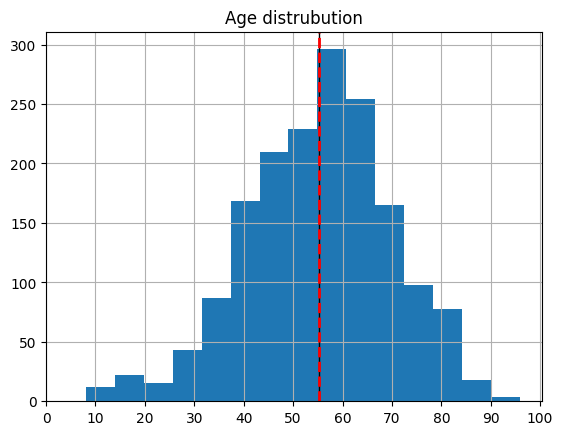

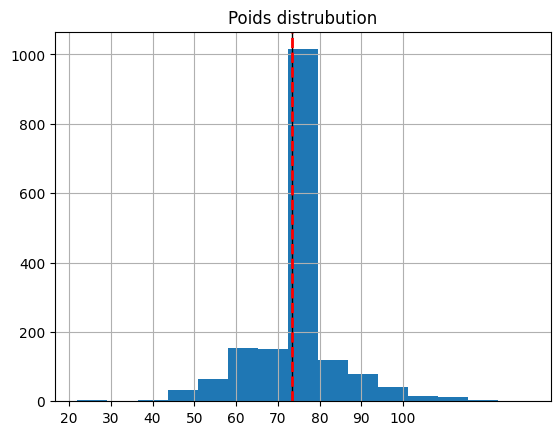

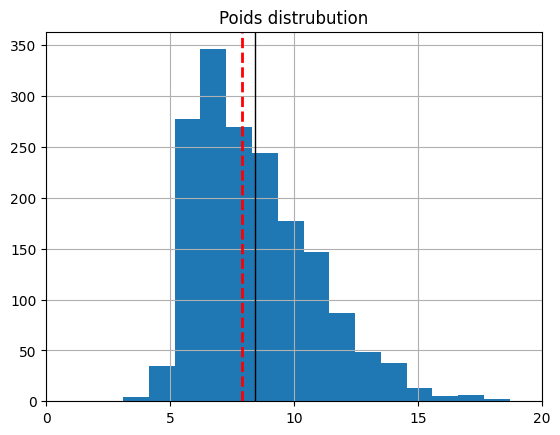

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

#plotting age
df['Age'].hist(bins = 15)
plt.axvline(df['Age'].mean(), color='k', linewidth=1)
plt.axvline(df['Age'].median(), color='r', linestyle='dashed', linewidth=2)
plt.title('Age distrubution')
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

df['Poids'].hist(bins = 15)
plt.axvline(df['Poids'].mean(), color='k', linewidth=1)
plt.axvline(df['Poids'].median(), color='r', linestyle='dashed', linewidth=2)
plt.title('Poids distrubution')
plt.xticks([20,30,40,50,60,70,80,90,100])
plt.show()


df['%'].hist(bins = 15)
plt.axvline(df['%'].mean(), color='k', linewidth=1)
plt.axvline(df['%'].median(), color='r', linestyle='dashed', linewidth=2)
plt.title('Poids distrubution')
plt.xticks([0,5,10,15,20])
plt.show()



### The data are almost well distributed

## Now we train a model

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import OrdinalEncoder

# getting the feature and trget data sets
X = df.drop('Type',axis=1)
y = df.copy()

# encoding the target
ordinale_encoder = OrdinalEncoder()
y['Type'] = ordinale_encoder.fit_transform(y[['Type']])
y.drop(['Age','Poids','%'],axis = 1,inplace=True)

# getting the translation
encoderType = {}
encoderTypeinverse = {}
for i in range(len(y['Type'].value_counts())) : 
    encoderType[df['Type'].value_counts().index[i]] = y['Type'].value_counts().index[i]
    encoderTypeinverse[y['Type'].value_counts().index[i]] = df['Type'].value_counts().index[i]
#display(encoderType)

# train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y['Type'],test_size=0.2,random_state=19)

In [78]:
display(encoderType)

{'2em TYPE': 1.0,
 'RAS': 5.0,
 '1er type': 0.0,
 'PRES DIAB': 4.0,
 'GESTA': 2.0,
 'MODY': 3.0}

### for the first tiem we will use a Random forest classification model ad try to find the best parameters 

In [89]:
from sklearn.ensemble import RandomForestClassifier

rfModel = RandomForestClassifier(random_state=19)
rfModel.fit(Xtrain,ytrain)
prediction = rfModel.predict(Xtest)

# we evaluate the model
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score

#classification score 
print(classification_report(ytest,prediction))

#confusion metrics
confusion_matrix(ytest,prediction)

# cross validation score
scores = cross_val_score(rfModel,X,y['Type'],cv = 5)
scores_no_gridsearch = scores.mean()
print('the score\'s mean is: ',scores_no_gridsearch)

# display(ytest.map(encoderTypeinverse).value_counts())
# print('\n')
# display(pd.Series(prediction).map(encoderTypeinverse).value_counts())

              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76        15
         1.0       0.94      0.97      0.96       299
         2.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         4
         5.0       0.69      0.52      0.59        21

    accuracy                           0.92       340
   macro avg       0.48      0.45      0.46       340
weighted avg       0.91      0.92      0.91       340



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


the score's mean is:  0.9093492972410203


### we need to find now the best parameters for this model using gridSearch

In [91]:
from sklearn.model_selection import GridSearchCV
import time 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}


# setting up the grid search
grid_search = GridSearchCV(
    estimator = rfModel,
    param_grid = param_grid,
    n_jobs= -1,
    scoring='f1_weighted',
    cv=5,
)

start_time = time.time()

grid_search.fit(Xtrain,ytrain)

end_time = time.time()
print('\nthe fit took: ',end_time - start_time,'\n')

best_rf_model = grid_search.best_estimator_
print("\nthe best parameters are: ",grid_search.best_params_,'\n')

# we scrore the model
prediction = best_rf_model.predict(Xtest)
#classification score 
print(classification_report(ytest,prediction))

#confusion metrics
confusion_matrix(ytest,prediction)

# cross validation score
scores = cross_val_score(best_rf_model,X,y['Type'],cv = 5)
scores_with_gridsearch = scores.mean()

print('the score\'s mean is: ',scores_with_gridsearch)
print('\ncomparing the two means :\nno grid ',scores_no_gridsearch,"\nwith grid",scores_with_gridsearch)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



the fit took:  17.403545379638672 


the best parameters are:  {'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} 

              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76        15
         1.0       0.94      0.97      0.96       299
         2.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         4
         5.0       0.65      0.52      0.58        21

    accuracy                           0.91       340
   macro avg       0.48      0.44      0.46       340
weighted avg       0.91      0.91      0.91       340



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


the score's mean is:  0.9093458268263056

comparing the two means :
no grid  0.9093492972410203 
with grid 0.9093458268263056
